# Title I Allocations w/ DP ACS

In [2]:
from dp_policy.api import titlei_funding as funding, titlei_grid as test_params
from dp_policy.titlei.allocators import AbowdAllocator, SonnenbergAuthorizer
from dp_policy.titlei.utils import weighting
from dp_policy.titlei.mechanisms import Laplace, Gaussian, GroundTruth
from dp_policy.titlei.utils import *
from dp_policy.titlei.thresholders import *
from dp_policy.titlei.evaluation import *

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns

saipe = get_inputs(2021)
sppe = get_sppe("../data/sppe18.xlsx")
print(saipe.shape)

plt.style.use('seaborn-deep')

%matplotlib inline
%load_ext autoreload
%autoreload 2

-- WARNING: dropping some balances from total budget --
Puerto Rico 412450771.2306171
County balances 723748.7996060263
Part D Subpart 2 104168000.98352575
(13190, 24)
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Allocation Algorithm

### Data
Need state per-pupil expenditure (SPPE) from the NCES. Most recent I can find in <5min is the [FY '18 data](https://nces.ed.gov/pubsearch/pubsinfo.asp?pubid=2020308).

Had to use an online tool to convert Table 2 of [this report](https://nces.ed.gov/pubs2020/2020308.pdf).

In [3]:
sppe = get_sppe("../data/sppe18.xlsx")
sppe.head()

state    ppe abbrv
0         Alabama   9697    AL
1          Alaska  17726    AK
2  American Samoa    NaN    AS
3         Arizona   8296    AZ
4        Arkansas  10072    AR

Also need a dict matching district IDs to district names to states. Simplest to use [SAIPE 2019](https://www2.census.gov/programs-surveys/saipe/datasets/2019/2019-school-districts/) ground-truth.

Also, a method for roughly estimating standard errors for the SAIPE estimates, based on [these published docs](https://www.census.gov/programs-surveys/saipe/guidance/district-estimates.html). This could be improved - but start with this as a shortcut.

In [62]:
saipe.head()

State Postal Code                         Name  \
State FIPS Code District ID                                                  
1               1                          AL  Fort Rucker School District   
                1                          AL  Fort Rucker School District   
                1                          AL  Fort Rucker School District   
                1                          AL  Fort Rucker School District   
                1                          AL  Fort Rucker School District   

                             Estimated Total Population  \
State FIPS Code District ID                               
1               1                                  4547   
                1                                  4547   
                1                                  4547   
                1                                  4547   
                1                                  4547   

                             Estimated Population 5-17  \
State FIPS Code District ID                              
1               1                                  861   
                1                                  861   
                1                                  861   
                1                                  861   
                1                                  861   

                             Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder  \
State FIPS Code District ID                                                                                                          
1               1                                                          133                                                       
                1                                                          133                                                       
                1                                                          133                                                       
                1                                                          133                                                       
                1                                                          133                                                       

                               cv     LEAID  Sort C    State  \
State FIPS Code District ID                                    
1               1            0.42  100001.0     1.0  ALABAMA   
                1            0.42  100003.0     1.0  ALABAMA   
                1            0.42  100005.0     1.0  ALABAMA   
                1            0.42  100006.0     1.0  ALABAMA   
                1            0.42  100007.0     1.0  ALABAMA   

                             Basic Hold Harmless  ...  \
State FIPS Code District ID                       ...   
1               1                   6.145069e+04  ...   
                1                   2.085941e+04  ...   
                1                   8.205345e+05  ...   
                1                   1.319212e+06  ...   
                1                   6.089449e+05  ...   

                             Hold Harmless Percentage  Resident Pop.  \
State FIPS Code District ID                                            
1               1                            1.505202         4547.0   
                1                            0.850000         2482.0   
                1                            0.900000        22051.0   
                1                            0.901848        49087.0   
                1                            0.936605        83044.0   

                             Total Formula Count  5-17 Pop.  Percent Formula  \
State FIPS Code District ID                                                    
1               1                          135.0      861.0         0.156794   
                1                           27.0      243.0         0.111111   
                1                          971.

In [63]:
# average school district student pop
saipe["Estimated Population 5-17"].mean()
saipe["Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder"].mean()

104.63089683773975

### Code

Next, a class for the different ways we might allocate funds based on the poverty estimates (e.g. Abowd's shortcut method vs. the full Sonnenberg method).

Finally, the main method for computing estimates, then grant amounts.

-- WARNING: dropping some balances from total budget --
Puerto Rico 413911155.7939328
County balances 728460.8149536257
Part D Subpart 2 98548579.79236995
15836763981.599205


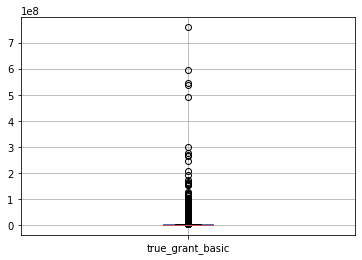

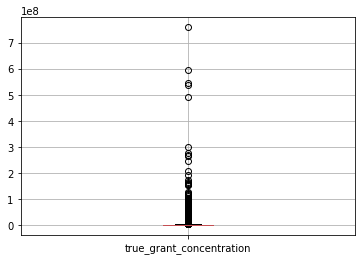

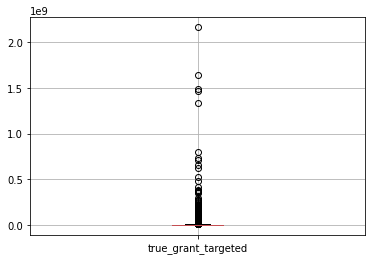

In [236]:
# Test with ground truth mechanism
saipe = get_inputs(2021)
grants = funding(SonnenbergAuthorizer, saipe, GroundTruth(), get_sppe("../data/sppe18.xlsx"))
grants.boxplot('true_grant_basic')
plt.show()
grants.boxplot('true_grant_concentration')
plt.show()
grants.boxplot('true_grant_targeted')
plt.show()

## Ground Truth Comparison
How close are our allocation estimates to the actual allocations from 2019? Note that we only have 2020's allocations, when really we need 2021's allocations, which will use the 2019 ACS data (see [here](https://www.nd.gov/dpi/sites/www/files/documents/Educational%20Equity%20%26%20Support/Title%20I/USED%20Census%202019%20Memo.pdf)). But historically the numbers are close.

-- WARNING: dropping some balances from total budget --
Puerto Rico 412450771.2306171
County balances 723748.7996060263
Part D Subpart 2 104168000.98352575
total
Average error -7.060823158570724e-11
RMSE 267898.8913773343 (average alloc is 1200349.4811968347 )


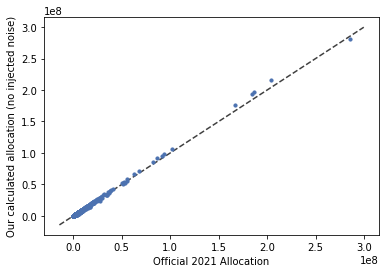

Name  official_basic_hold_harmless  \
State FIPS Code District ID                                               
36              82047        Kings County                  8.827453e+07   

                             official_concentration_hold_harmless  \
State FIPS Code District ID                                         
36              82047                                2.182134e+07   

                             official_targeted_hold_harmless  \
State FIPS Code District ID                                    
36              82047                           9.270965e+07   

                             official_efig_hold_harmless  \
State FIPS Code District ID                                
36              82047                       8.319514e+07   

                             official_total_hold_harmless  \
State FIPS Code District ID                                 
36              82047                        2.860007e+08   

                             official_basic_alloc  \
State FIPS Code District ID                         
36              82047                8.712931e+07   

                             official_concentration_alloc  \
State FIPS Code District ID                                 
36              82047                        2.210905e+07   

                             official_targeted_alloc  official_efig_alloc  \
State FIPS Code District ID                                                 
36              82047                   9.498686e+07         8.667319e+07   

                             ...  dpest_eligible_basic  \
State FIPS Code District ID  ...                         
36              82047        ...                  True   

                             dpest_grant_concentration  \
State FIPS Code District ID                              
36              82047                     2.172240e+07   

                             dpest_eligible_concentration  \
State FIPS Code District ID                                 
36              82047                                True   

                             dpest_grant_targeted  dpest_eligible_targeted  \
State FIPS Code District ID                                                  
36              82047                8.466005e+07                     True   

                             true_grant_total  est_grant_total  \
State FIPS Code District ID                                      
36              82047            2.153510e+08     1.844383e+08   

                             dp_grant_total  dpest_grant_total         error  
State FIPS Code District ID                                                   
36              82047          2.153510e+08       1.844383e+08 -1.112577e+07  

[1 rows x 67 columns]

basic
Average error -1.0450018274684671e-11
RMSE 93867.8964035751 (average alloc is 1200349.4811968347 )


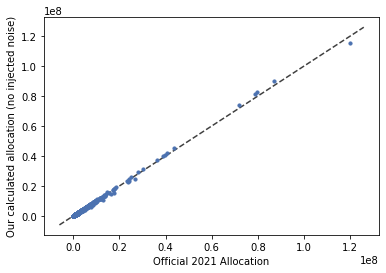

Name  official_basic_hold_harmless  \
State FIPS Code District ID                                               
36              82047        Kings County                  8.827453e+07   

                             official_concentration_hold_harmless  \
State FIPS Code District ID                                         
36              82047                                2.182134e+07   

                             official_targeted_hold_harmless  \
State FIPS Code District ID                                    
36              82047                           9.270965e+07   

                             official_efig_hold_harmless  \
State FIPS Code District ID                                
36              82047                       8.319514e+07   

                             official_total_hold_harmless  \
State FIPS Code District ID                                 
36              82047                        2.860007e+08   

                             official_basic_alloc  \
State FIPS Code District ID                         
36              82047                8.712931e+07   

                             official_concentration_alloc  \
State FIPS Code District ID                                 
36              82047                        2.210905e+07   

                             official_targeted_alloc  official_efig_alloc  \
State FIPS Code District ID                                                 
36              82047                   9.498686e+07         8.667319e+07   

                             ...  dpest_eligible_basic  \
State FIPS Code District ID  ...                         
36              82047        ...                  True   

                             dpest_grant_concentration  \
State FIPS Code District ID                              
36              82047                     3.247885e+07   

                             dpest_eligible_concentration  \
State FIPS Code District ID                                 
36              82047                                True   

                             dpest_grant_targeted  dpest_eligible_targeted  \
State FIPS Code District ID                                                  
36              82047                1.304930e+08                     True   

                             true_grant_total  est_grant_total  \
State FIPS Code District ID                                      
36              82047            2.153510e+08     2.794623e+08   

                             dp_grant_total  dpest_grant_total         error  
State FIPS Code District ID                                                   
36              82047          2.153510e+08       2.794623e+08 -2.907847e+06  

[1 rows x 67 columns]

concentration
Average error -1.5745635643612715e-11
RMSE 85392.67792116926 (average alloc is 1200349.4811968347 )


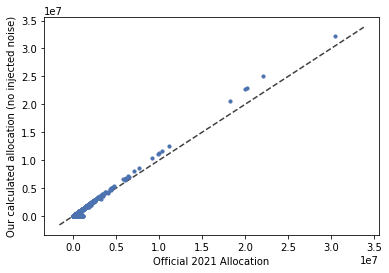

Name  official_basic_hold_harmless  \
State FIPS Code District ID                                               
36              82047        Kings County                  8.827453e+07   

                             official_concentration_hold_harmless  \
State FIPS Code District ID                                         
36              82047                                2.182134e+07   

                             official_targeted_hold_harmless  \
State FIPS Code District ID                                    
36              82047                           9.270965e+07   

                             official_efig_hold_harmless  \
State FIPS Code District ID                                
36              82047                       8.319514e+07   

                             official_total_hold_harmless  \
State FIPS Code District ID                                 
36              82047                        2.860007e+08   

                             official_basic_alloc  \
State FIPS Code District ID                         
36              82047                8.712931e+07   

                             official_concentration_alloc  \
State FIPS Code District ID                                 
36              82047                        2.210905e+07   

                             official_targeted_alloc  official_efig_alloc  \
State FIPS Code District ID                                                 
36              82047                   9.498686e+07         8.667319e+07   

                             ...  dpest_eligible_basic  \
State FIPS Code District ID  ...                         
36              82047        ...                  True   

                             dpest_grant_concentration  \
State FIPS Code District ID                              
36              82047                     3.070087e+07   

                             dpest_eligible_concentration  \
State FIPS Code District ID                                 
36              82047                                True   

                             dpest_grant_targeted  dpest_eligible_targeted  \
State FIPS Code District ID                                                  
36              82047                1.219005e+08                     True   

                             true_grant_total  est_grant_total  \
State FIPS Code District ID                                      
36              82047            2.153510e+08     2.623403e+08   

                             dp_grant_total  dpest_grant_total         error  
State FIPS Code District ID                                                   
36              82047          2.153510e+08       2.623403e+08 -2.931902e+06  

[1 rows x 67 columns]

targeted
Average error -4.6036566993881124e-11
RMSE 123934.14686914106 (average alloc is 1200349.4811968347 )


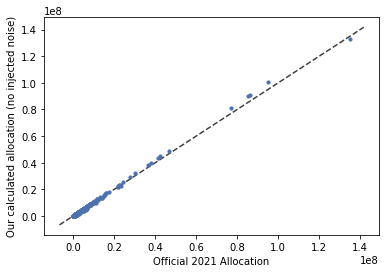

Name  official_basic_hold_harmless  \
State FIPS Code District ID                                               
36              82047        Kings County                  8.827453e+07   

                             official_concentration_hold_harmless  \
State FIPS Code District ID                                         
36              82047                                2.182134e+07   

                             official_targeted_hold_harmless  \
State FIPS Code District ID                                    
36              82047                           9.270965e+07   

                             official_efig_hold_harmless  \
State FIPS Code District ID                                
36              82047                       8.319514e+07   

                             official_total_hold_harmless  \
State FIPS Code District ID                                 
36              82047                        2.860007e+08   

                             official_basic_alloc  \
State FIPS Code District ID                         
36              82047                8.712931e+07   

                             official_concentration_alloc  \
State FIPS Code District ID                                 
36              82047                        2.210905e+07   

                             official_targeted_alloc  official_efig_alloc  \
State FIPS Code District ID                                                 
36              82047                   9.498686e+07         8.667319e+07   

                             ...  dpest_eligible_basic  \
State FIPS Code District ID  ...                         
36              82047        ...                  True   

                             dpest_grant_concentration  \
State FIPS Code District ID                              
36              82047                     2.632713e+07   

                             dpest_eligible_concentration  \
State FIPS Code District ID                                 
36              82047                                True   

                             dpest_grant_targeted  dpest_eligible_targeted  \
State FIPS Code District ID                                                  
36              82047                1.036225e+08                     True   

                             true_grant_total  est_grant_total  \
State FIPS Code District ID                                      
36              82047            2.153510e+08     2.242385e+08   

                             dp_grant_total  dpest_grant_total         error  
State FIPS Code District ID                                                   
36              82047          2.153510e+08       2.242385e+08 -5.286022e+06  

[1 rows x 67 columns]

In [4]:
saipe = get_inputs(2021)
def compare_allocs(grant_type="total", **kwargs):
    allocs = funding(
        SonnenbergAuthorizer, saipe, GroundTruth(), sppe,
        allocator_kwargs=kwargs
    )
    if grant_type == "total":
        official = allocs[f"official_total_alloc"] - allocs[f"official_efig_alloc"]
    else:
        official = allocs[f"official_{grant_type}_alloc"]
    calculated = allocs[f"true_grant_{grant_type}"]
    allocs["error"] = official - calculated
    print("Average error", allocs.error.mean())
    print(
        "RMSE", 
        np.sqrt(np.mean(np.power(allocs.error, 2))), 
        "(average alloc is", 
        np.mean(allocs[f"official_total_alloc"]), 
        ")"
    )

    ax = plt.gca()
    plt.scatter(official, calculated, s=10)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
    plt.xlabel("Official 2021 Allocation")
    plt.ylabel("Our calculated allocation (no injected noise)")
    plt.savefig(f"../plots/robustness/official_{grant_type}.png", dpi=300)
    plt.show()

    # plt.hist(allocs.error, bins=50)
    # plt.show()

    display(allocs[allocs.error == allocs.error.min()])

for grant_type in ["total", "basic", "concentration", "targeted"]:
    print(grant_type)
    compare_allocs(grant_type=grant_type)

## Laplace

### Results
First, using the full Sonnenberg authorization algo.

In [34]:
results = test_params(saipe, Laplace, eps=[0.1, 1.0, 2.52, 10.0]+list(np.logspace(-4, 1, num=10)), trials=100, print_results=False)
results.to_csv("../results/titlei_laplace.csv")

1400 iters:


trial:   0%|          | 0/100 [00:00<?, ?it/s]

In [3]:
results = pd.read_csv("../results/titlei_laplace.csv").set_index(["trial", "delta", "epsilon", "State FIPS Code", "District ID"])

100
## est
## basic grants - eps=0.1 ##
# districts: 1319000
Average true alloc: 469099.6911697106
Max true alloc: 115755955.49502522
Max error: 41035763.48263691
RMSE: 340280.6769134945
RMSE in exp. error: 28156.36589946104
Avg. sum of negative misallocs: 50146935.12403834
Avg. total misalloc: 100293870.24807608
# small districts: 9744
Total avg misalloc to large districts: 68713681.6525161
Total avg misalloc to small districts: 31580188.595560405
Avg total true alloc: 6187424926.528488
## concentration grants - eps=0.1 ##
# districts: 1319000
Average true alloc: 98353.3515922628
Max true alloc: 32193815.515176307
Max error: 11457899.785159744
RMSE: 112735.00598913326
RMSE in exp. error: 31960.779443541778
Avg. sum of negative misallocs: 66352163.29665016
Avg. total misalloc: 132704326.59330022
# small districts: 9744
Total avg misalloc to large districts: 88826771.56143445
Total avg misalloc to small districts: 43877555.031865895
Avg total true alloc: 1297280707.5019464
## targeted g

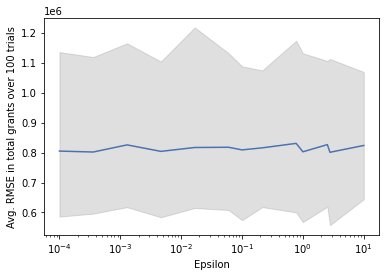

## dpest
## basic grants - eps=0.1 ##
# districts: 1319000
Average true alloc: 469099.6911697106
Max true alloc: 115755955.49502522
Max error: 41161725.97893828
RMSE: 340241.59562898113
RMSE in exp. error: 28955.553617735473
Avg. sum of negative misallocs: 57123146.20699972
Avg. total misalloc: 114246292.41399936
# small districts: 9744
Total avg misalloc to large districts: 70253946.62912199
Total avg misalloc to small districts: 43992345.78487729
Avg total true alloc: 6187424926.528488
## concentration grants - eps=0.1 ##
# districts: 1319000
Average true alloc: 98353.3515922628
Max true alloc: 32193815.515176307
Max error: 11539111.485453427
RMSE: 112450.72309552525
RMSE in exp. error: 32521.182082193594
Avg. sum of negative misallocs: 71369248.57953453
Avg. total misalloc: 142738497.1590689
# small districts: 9744
Total avg misalloc to large districts: 91296791.80821495
Total avg misalloc to small districts: 51441705.35085409
Avg total true alloc: 1297280707.5019464
## targeted gra

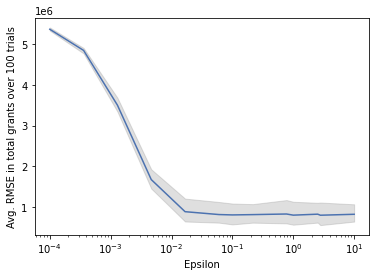

Name  \
trial delta epsilon State FIPS Code District ID                                        
0     0.0   0.1     1               190               Alabaster City School District   
                                    5               Albertville City School District   
                                    30           Alexander City City School District   
                                    60                Andalusia City School District   
                                    90                 Anniston City School District   
...                                                                              ...   
99    0.0   10.0    56              4260              Uinta County School District 6   
                                    6240           Washakie County School District 1   
                                    5820           Washakie County School District 2   
                                    4830             Weston County School District 1   
                                    6090             Weston County School District 7   

                                                 official_basic_hold_harmless  \
trial delta epsilon State FIPS Code District ID                                 
0     0.0   0.1     1               190                         451569.585546   
                                    5                           820486.906460   
                                    30                          548830.474149   
                                    60                          255888.455695   
                                    90                          690724.128654   
...                                                                       ...   
99    0.0   10.0    56              4260                         40822.247350   
                                    6240                        223321.706091   
                                    5820                             0.000000   
                                    4830                        182499.458741   
                                    6090                         20411.123675   

                                                 official_concentration_hold_harmless  \
trial delta epsilon State FIPS Code District ID                                         
0     0.0   0.1     1               190                                  58092.627841   
                                    5                                   200836.024036   
                                    30                                  135670.119992   
                                    60                                   63255.265741   
                                    90                                  170746.031480   
...                                                                               ...   
99    0.0   10.0    56              4260                                     0.000000   
                                    6240                                 24485.720477   
                                    5820                                  5762.953584   
                                    4830                                 93609.867864   
                                    6090                                     0.000000   

                                                 official_targeted_hold_harmless  \
trial delta epsilon State FIPS Code District ID                                    
0     0.0   0.1     1               190                            182516.637263   
                                    5                              553590.326339   
                                    30                             392958.114409   
                                    60                             157617.381627   
                                    90                             537272.595916   
...                                                                          ...   
99    0.0   10.0    56              4260           

In [4]:
print(len(results.groupby("trial")))
test_params(None, None, results=results, plot_results=True)

### Sanity check: using Abowd's method

Abowd reported a mean squared SPPE of 20 million from 2014-15 data.

In [12]:
grants = funding(AbowdAllocator, saipe, Laplace(2.52, 0, sensitivity=2.0), get_sppe("../data/sppe18.xlsx"))
print("Mean Sq. SPPE (2018):", np.mean(grants.adj_sppe**2))

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
Mean Sq. SPPE (2018): 26235395.69087739


They also report an RMSE at e=2.52 of 2509 (again, using 2014-15 Common Core data, which I can't replicate) and 1334 at e=4.74 and 63000 at e=0.1. 

In [13]:
# RMSE
error = grants.true_grant_total - grants.dp_grant_total
np.sqrt(np.mean(error**2))

5729.419640458363

In [14]:
print("Total misalloc at eps=2.52:", sum(abs(error)))

Total misalloc at eps=2.52: 52390267.7563839


In [15]:
grants = funding(AbowdAllocator, saipe, Laplace(4.74, 0), get_sppe("../data/sppe18.xlsx"))
error = grants.true_grant_total - grants.dp_grant_total
np.sqrt(np.mean(error**2))

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


3007.91078773349

In [17]:
grants = funding(AbowdAllocator, saipe, Laplace(0.1, 0), get_sppe("../data/sppe18.xlsx"))
error = grants.true_grant_total - grants.est_grant_total
np.sqrt(np.mean(error**2))

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


2243651.00695352

## Gaussian (Advanced Composition, Approx. DP)

Add Gaussian noise ln(1/delta)/epsilon for better accuracy bound.

/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/diffprivlib/mechanisms/gaussian.py:161: RuntimeWarning: overflow encountered in exp
  return phi(np.sqrt(epsilon * val)) - np.exp(epsilon) * phi(- np.sqrt(epsilon * (val + 2))) - delta
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/diffprivlib/mechanisms/gaussian.py:161: RuntimeWarning: invalid value encountered in double_scalars
  return phi(np.sqrt(epsilon * val)) - np.exp(epsilon) * phi(- np.sqrt(epsilon * (val + 2))) - delta
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/diffprivlib/mechanisms/gaussian.py:164: RuntimeWarning: overflow encountered in exp
  return phi(- np.sqrt(epsilon * val)) - np.exp(epsilon) * phi(- np.sqrt(epsilon * (val + 2))) - delta
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/diffprivlib/mechanisms/gaussian.py:164: RuntimeWarning: invalid value encountered in double_scalars
  return phi(- np.sqrt(epsilon * val)) - np.exp(epsilon) * phi(- np.sqrt(epsilon * (val + 2))) - delta


(0.001, 0.027825594022071243, 0.774263682681127, 2.52, 21.54434690031882, 599.4842503189409, 16681.005372000593, 464158.8833612772, 12915496.650148828, 359381366.3804626, 10000000000.0)
## dp
## basic grants ##
RMSE at eps=2.52: 21399.19796113853
RMSE prop eps=2.52: 0.004691125745169814
Total misalloc at eps=2.52: 1857499037.3476112
Total true alloc: 398753867558.1087
## concentration grants ##
RMSE at eps=2.52: 100671.3283797714
RMSE prop eps=2.52: 0.006430091290918551
Total misalloc at eps=2.52: 1869504093.5586305
Total true alloc: 294198199337.48425
## targeted grants ##
RMSE at eps=2.52: 56692.94880990919
RMSE prop eps=2.52: 0.004404833980625078
Total misalloc at eps=2.52: 2903765215.9326797
Total true alloc: 667259095030.0739
## total grants ##
RMSE at eps=2.52: 15266.238953544133
RMSE prop eps=2.52: 0.00492429570329448
Total misalloc at eps=2.52: 787839065.3432262
Total true alloc: 159990202216.03195


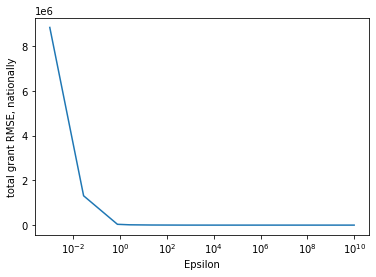

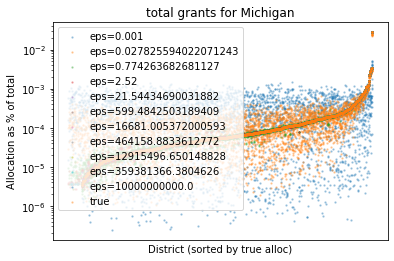

/Users/steed/dp-acs/dp_policy/api.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alloc['err_prop'] = (


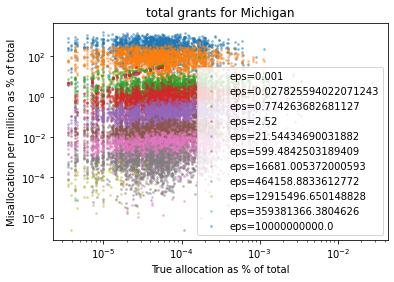

## dpest
## basic grants ##
RMSE at eps=2.52: 2730892.7708471036
RMSE prop eps=2.52: 0.1605220789051688
Total misalloc at eps=2.52: 64100091418.47471
Total true alloc: 398753867558.1087
## concentration grants ##
RMSE at eps=2.52: 3115379.4280794035
RMSE prop eps=2.52: 0.2559038715010952
Total misalloc at eps=2.52: 75780426908.8416
Total true alloc: 294198199337.48425
## targeted grants ##
RMSE at eps=2.52: 7905797.344754197
RMSE prop eps=2.52: 0.20086854941523397
Total misalloc at eps=2.52: 136090233079.47676
Total true alloc: 667259095030.0739
## total grants ##
RMSE at eps=2.52: 1550976.8201538778
RMSE prop eps=2.52: 0.20096552176913365
Total misalloc at eps=2.52: 32152514466.29373
Total true alloc: 159990202216.03195


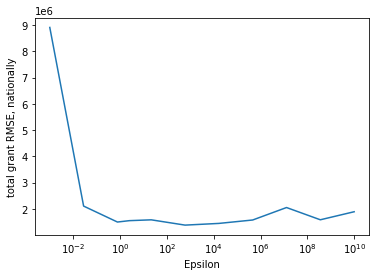

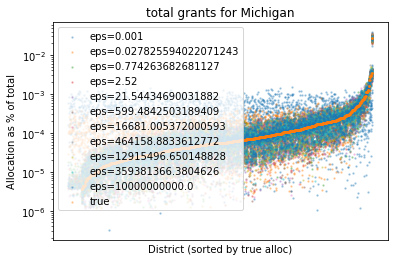

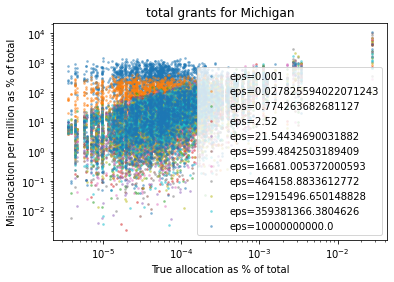

In [18]:
from dp_policy.titlei.mechanisms import Gaussian

# with delta = 0
results = test_params(
    saipe,
    Gaussian, 
    delta=list(np.linspace(1e-8, 1e-5, endpoint=False, num=10)),
    auth=False
)
results.to_csv("../results/titlei_gaussian.csv")

In [19]:
results = pd.read_csv("../results/titlei_gaussian.csv").set_index(['delta', 'epsilon', 'State FIPS Code', 'District ID'])
results.head()

trial State Postal Code  \
delta        epsilon State FIPS Code District ID                            
1.000000e-08 0.001   1               190              0                AL   
                                     5                0                AL   
                                     30               0                AL   
                                     60               0                AL   
                                     90               0                AL   

                                                                                 Name  \
delta        epsilon State FIPS Code District ID                                        
1.000000e-08 0.001   1               190               Alabaster City School District   
                                     5               Albertville City School District   
                                     30           Alexander City City School District   
                                     60                Andalusia City School District   
                                     90                 Anniston City School District   

                                                  true_pop_total  \
delta        epsilon State FIPS Code District ID                   
1.000000e-08 0.001   1               190                   34669   
                                     5                     22051   
                                     30                    16920   
                                     60                     8842   
                                     90                    22043   

                                                  true_children_total  \
delta        epsilon State FIPS Code District ID                        
1.000000e-08 0.001   1               190                         6710   
                                     5                           4131   
                                     30                          2575   
                                     60                          1465   
                                     90                          3065   

                                                  true_children_poverty    cv  \
delta        epsilon State FIPS Code District ID                                
1.000000e-08 0.001   1               190                            649  0.23   
                                     5                              957  0.23   
                                     30                             703  0.28   
                                     60                             406  0.35   
                                     90                            1057  0.23   

                                                  est_pop_total  \
delta        epsilon State FIPS Code District ID                  
1.000000e-08 0.001   1               190                  34669   
                                     5                    22051   
                                     30                   16920   
                                     60                    8842   
                                     90                   22043   

                                                  est_children_total  \
delta        epsilon State FIPS Code District ID                       
1.000000e-08 0.001   1               190                        6710   
                                     5                          4131   
                                     30                         2575   
                                     60                         1465   
                                     90                         3065   

                                                  est_children_poverty  ...  \
delta        epsilon State FIPS Code District ID                        ...   
1.000000e-08 0.001   1               190                    501.287375  ...   
                                     5                      920.205347  ...   
                                     3

Comparing dp


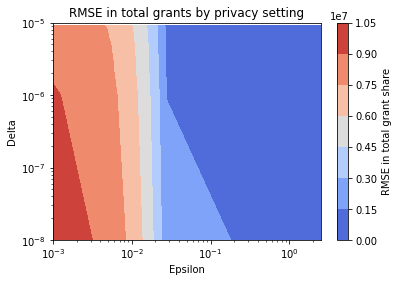

Comparing dpest


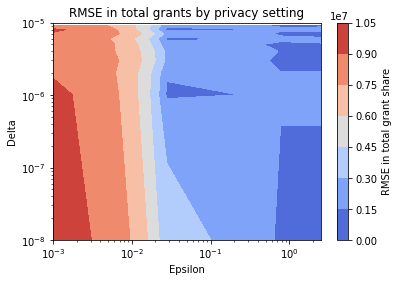

In [25]:
for prefix in ('dp', 'dpest'):
    print("Comparing", prefix)

    grant_type = 'total'

    eps = list(results.index.get_level_values("epsilon").unique())

    delts = list(results.index.get_level_values("delta").unique())
    mse = np.zeros((len(eps), len(delts)))
    for params, alloc in results.groupby(["epsilon", "delta"]):
        
        e, d = params
        error = alloc[f"true_grant_{grant_type}"] \
            - alloc[f"{prefix}_grant_{grant_type}"]
        mse[eps.index(e), delts.index(d)] = np.sqrt(sum(error**2)/alloc.shape[0])
        
    plt.contourf(eps, delts, mse.transpose(), cmap="coolwarm")
    ax = plt.gca()
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_yticks([1e-8, 1e-7, 1e-6, 1e-5])
    # ax.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
    plt.xlim(None, 2.5)
    plt.xlabel("Epsilon")
    plt.ylabel("Delta")
    plt.title("RMSE in total grants by privacy setting")
    plt.colorbar(label="RMSE in total grant share")
    plt.show()

## Uncertainty

Adapted from `plot_sampling.ipynb`.

In [49]:
num_trials = 100
eps = [0.001, 0.01, 0.1, 1.0, 10]
num_bins = 10

In [3]:
laplace = test_params(saipe, Laplace, eps=[0.001, 0.01, 0.1, 1.0, 10], delta=[0.0], trials=num_trials, print_results=False, plot_results=False)
# gaussian = test_params(saipe, Gaussian, eps=[0.01, 0.1, 2.52], delta=[1e-6], trials=num_trials, print_results=False, plot_results=False)

pickle.dump(laplace, open("../results/bootstrap/laplace.pkl", 'wb'))
# pickle.dump(gaussian, open("../results/bootstrap/gaussian.pkl", 'wb'))

500 iters:


trial:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
baseline = test_params(saipe, GroundTruth, eps=[0.0], delta=[0.0], trials=num_trials, print_results=False, plot_results=False)
pickle.dump(baseline, open("../results/bootstrap/baseline.pkl", 'wb'))

In [50]:
baseline = pickle.load(open("../results/bootstrap/baseline.pkl", 'rb'))
laplace = pickle.load(open("../results/bootstrap/laplace.pkl", 'rb'))
# gaussian = pickle.load(open("../results/bootstrap/gaussian.pkl", 'rb'))

In [ ]:
treatments = {
  "+ Laplace mech. (ε={})".format(e): laplace.loc[pd.IndexSlice[:, 0.0, e, :, :], :].copy()
  for e in eps
}
treatments["Data error"] = baseline

plot_treatments(
  treatments,
  lambda df: df.groupby('trial')["lost_eligibility"].sum(),
  plt.hist,
  dict(bins=num_bins, alpha=0.5),
  filename="ineligible_hist",
  xlab="# districts wrongly ineligible",
  ylab="Trials"
)

for grant in [
  "basic",
  "concentration",
  "targeted",
  "total"
]:
  plot_treatments(
    treatments,
    lambda df: df.groupby(['State FIPS Code', 'District ID'])["lost_eligibility"].mean(),
    sns.kdeplot,
    dict(bw_method=0.5, fill=True),
    filename=f"likelihood_ineligible_{grant}",
    xlab=f"Likelihood of losing eligibility ({grant})",
    grant=grant,
    mean_line=True
  )

  plot_treatments(
    treatments,
    lambda df: np.sqrt(df.groupby('trial')["misalloc_sq"].mean()),
    sns.kdeplot,
    dict(bw_method=0.5, fill=True),
    filename=f"rmse_{grant}",
    xlab=f"RMSE for {grant} (per trial)",
    mean_line=True
  )

  plot_treatments(
    treatments,
    lambda df: \
      np.sign(df.groupby(['State FIPS Code', 'District ID'])["misalloc"].mean())*np.power(
        np.abs(df.groupby(['State FIPS Code', 'District ID'])["misalloc"].mean()), 1/3),
    sns.kdeplot,
    dict(bw_method=0.5, fill=True),
    filename=f"misalloc_{grant}",
    xlab=f"Misallocations, {grant} (cube root)",
    mean_line=True
  )

## Discrimination

### Data
Using 2014-2018 ACS race data by school district from the NCES. See notes for more details.

Data for just the total child population

In [128]:
acs = get_acs_unified(verbose=True)
print(acs.shape)
print(acs[acs['Total population (RACE) - est'].isna()].shape)
# print(list(c for c in acs.columns if "est" in c or "pct" in c))

(13294, 257)
(13293, 341)
(13294, 203)
(13294, 495)
(13293, 1296)
(0, 1296)


In [ ]:
from dp_policy.titlei.mechanisms import Gaussian

# run 100 trials for a signle eps, delta combo
eps = 0.1
f = '../results/discrimination_laplace_eps={}.pkl'.format(eps)
results = test_params(
    saipe,
    Laplace, 
    eps=[eps],
#     delta=[1e-6],
    trials=100
)
pickle.dump(results, open(f, 'wb'))

### Output

In [134]:
f = '../results/discrimination_laplace_eps=0.1.pkl'
# f = '../results/discrimination.pkl'

results = pickle.load(open(f, 'rb'))
print(results.shape)

grants = discrimination_join(results, save_path=f[:-4]+".csv", verbose=True)

(1318200, 48)
(13294, 257)
(13293, 341)
(13294, 203)
(13294, 495)
['Total population (RACE) - est', 'White (RACE) - pct', 'Black or African American (RACE) - pct', 'Cherokee tribal grouping (RACE) - pct', 'Chippewa tribal grouping (RACE) - pct', 'Navajo tribal grouping (RACE) - pct', 'Sioux tribal grouping (RACE) - pct', 'Asian (RACE) - pct', 'Asian Indian (RACE) - pct', 'Chinese (RACE) - pct', 'Filipino (RACE) - pct', 'Japanese (RACE) - pct', 'Korean (RACE) - pct', 'Vietnamese (RACE) - pct', 'Other Asian (RACE) - pct', 'Native Hawaiian (RACE) - pct', 'Guamanian or Chamorro (RACE) - pct', 'Samoan (RACE) - pct', 'Some other race (RACE) - pct', 'Two or more races (RACE) - pct', 'Mexican (HISPANIC OR LATINO AND RACE) - pct', 'Puerto Rican (HISPANIC OR LATINO AND RACE) - pct', 'Cuban (HISPANIC OR LATINO AND RACE) - pct', 'Other Hispanic or Latino (HISPANIC OR LATINO AND RACE) - pct', 'Not Hispanic or Latino (HISPANIC OR LATINO AND RACE) - pct', 'Median household income (dollars) (INCOME AN

In [135]:
# simple stats
income = pd.to_numeric(grants['Median household income (dollars) (INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)) - est'], errors='coerce')
print(
  "districts between 40,000 and 70,000 in income:", 
  np.sum((income > 40000) & (income < 70000)) / len(income)
)

density = np.log(grants["true_pop_total"] / grants["ALAND"])
print(
  "districts with high density",
  np.sum(density > -6) / len(density)
)

districts between 40,000 and 70,000 in income: 0.42323745920922823
districts with high density 0.019427790847689155


/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Geography

In [12]:
geo = get_geography()
joined = geo_join(results)
geo.loc[26].plot()

ELSDLEA                                                    None
SCSDLEA                                                    None
UNSDLEA                                                   00001
GEOID                                                   0100001
NAME                                Fort Rucker School District
LSAD                                                         00
LOGRADE                                                      KG
HIGRADE                                                      12
MTFCC                                                     G5420
SDTYP                                                         B
FUNCSTAT                                                      E
ALAND                                               232947983.0
AWATER                                                2801707.0
INTPTLAT                                            +31.4097368
INTPTLON                                           -085.7458071
GEO_YEAR                                

In [136]:
dperr = cube(joined.loc[[
    f for f in joined.index.get_level_values("State FIPS Code").unique()
    if f not in [2, 15]
]]["error_dp_per_child"])
dpmin = dperr.min()
dpmax = dperr.max()
serr = cube(joined.loc[[
    f for f in joined.index.get_level_values("State FIPS Code").unique()
    if f not in [2, 15]
]]["error_per_child"])
smin = serr.min()
smax = serr.max()
ymin = smin if smin <= dpmin else dpmin
ymax = smax if smax >= dpmax else dpmax
heatmap(
    joined.loc[[
        f for f in joined.index.get_level_values("State FIPS Code").unique()
        if f not in [2, 15]
    ]],
    label="Misallocation per child (cube root)",
    y="error_dp_per_child",
    file="misalloc_nation.png",
    figsize=(15,10),
    bar_location = 'right',
    # min=ymin,
    # max=ymax
)
heatmap(
    joined.loc[[
        f for f in joined.index.get_level_values("State FIPS Code").unique()
        if f not in [2, 15]
    ]],
    y="error_per_child",
    label="Misallocation per child (cube root)",
    file="misalloc_nation_sampling.png",
    figsize=(15,10),
    bar_location = 'right',
    min=ymin,
    max=ymax
)
heatmap(
    joined.loc[[
        f for f in joined.index.get_level_values("State FIPS Code").unique()
        if f not in [2, 15]
    ]],
    y="dp_marginal",
    label="Misallocation per child (cube root)",
    file="misalloc_nation_marginal.png",
    figsize=(15,10),
    bar_location = 'right'
)

NameError: name 'joined' is not defined

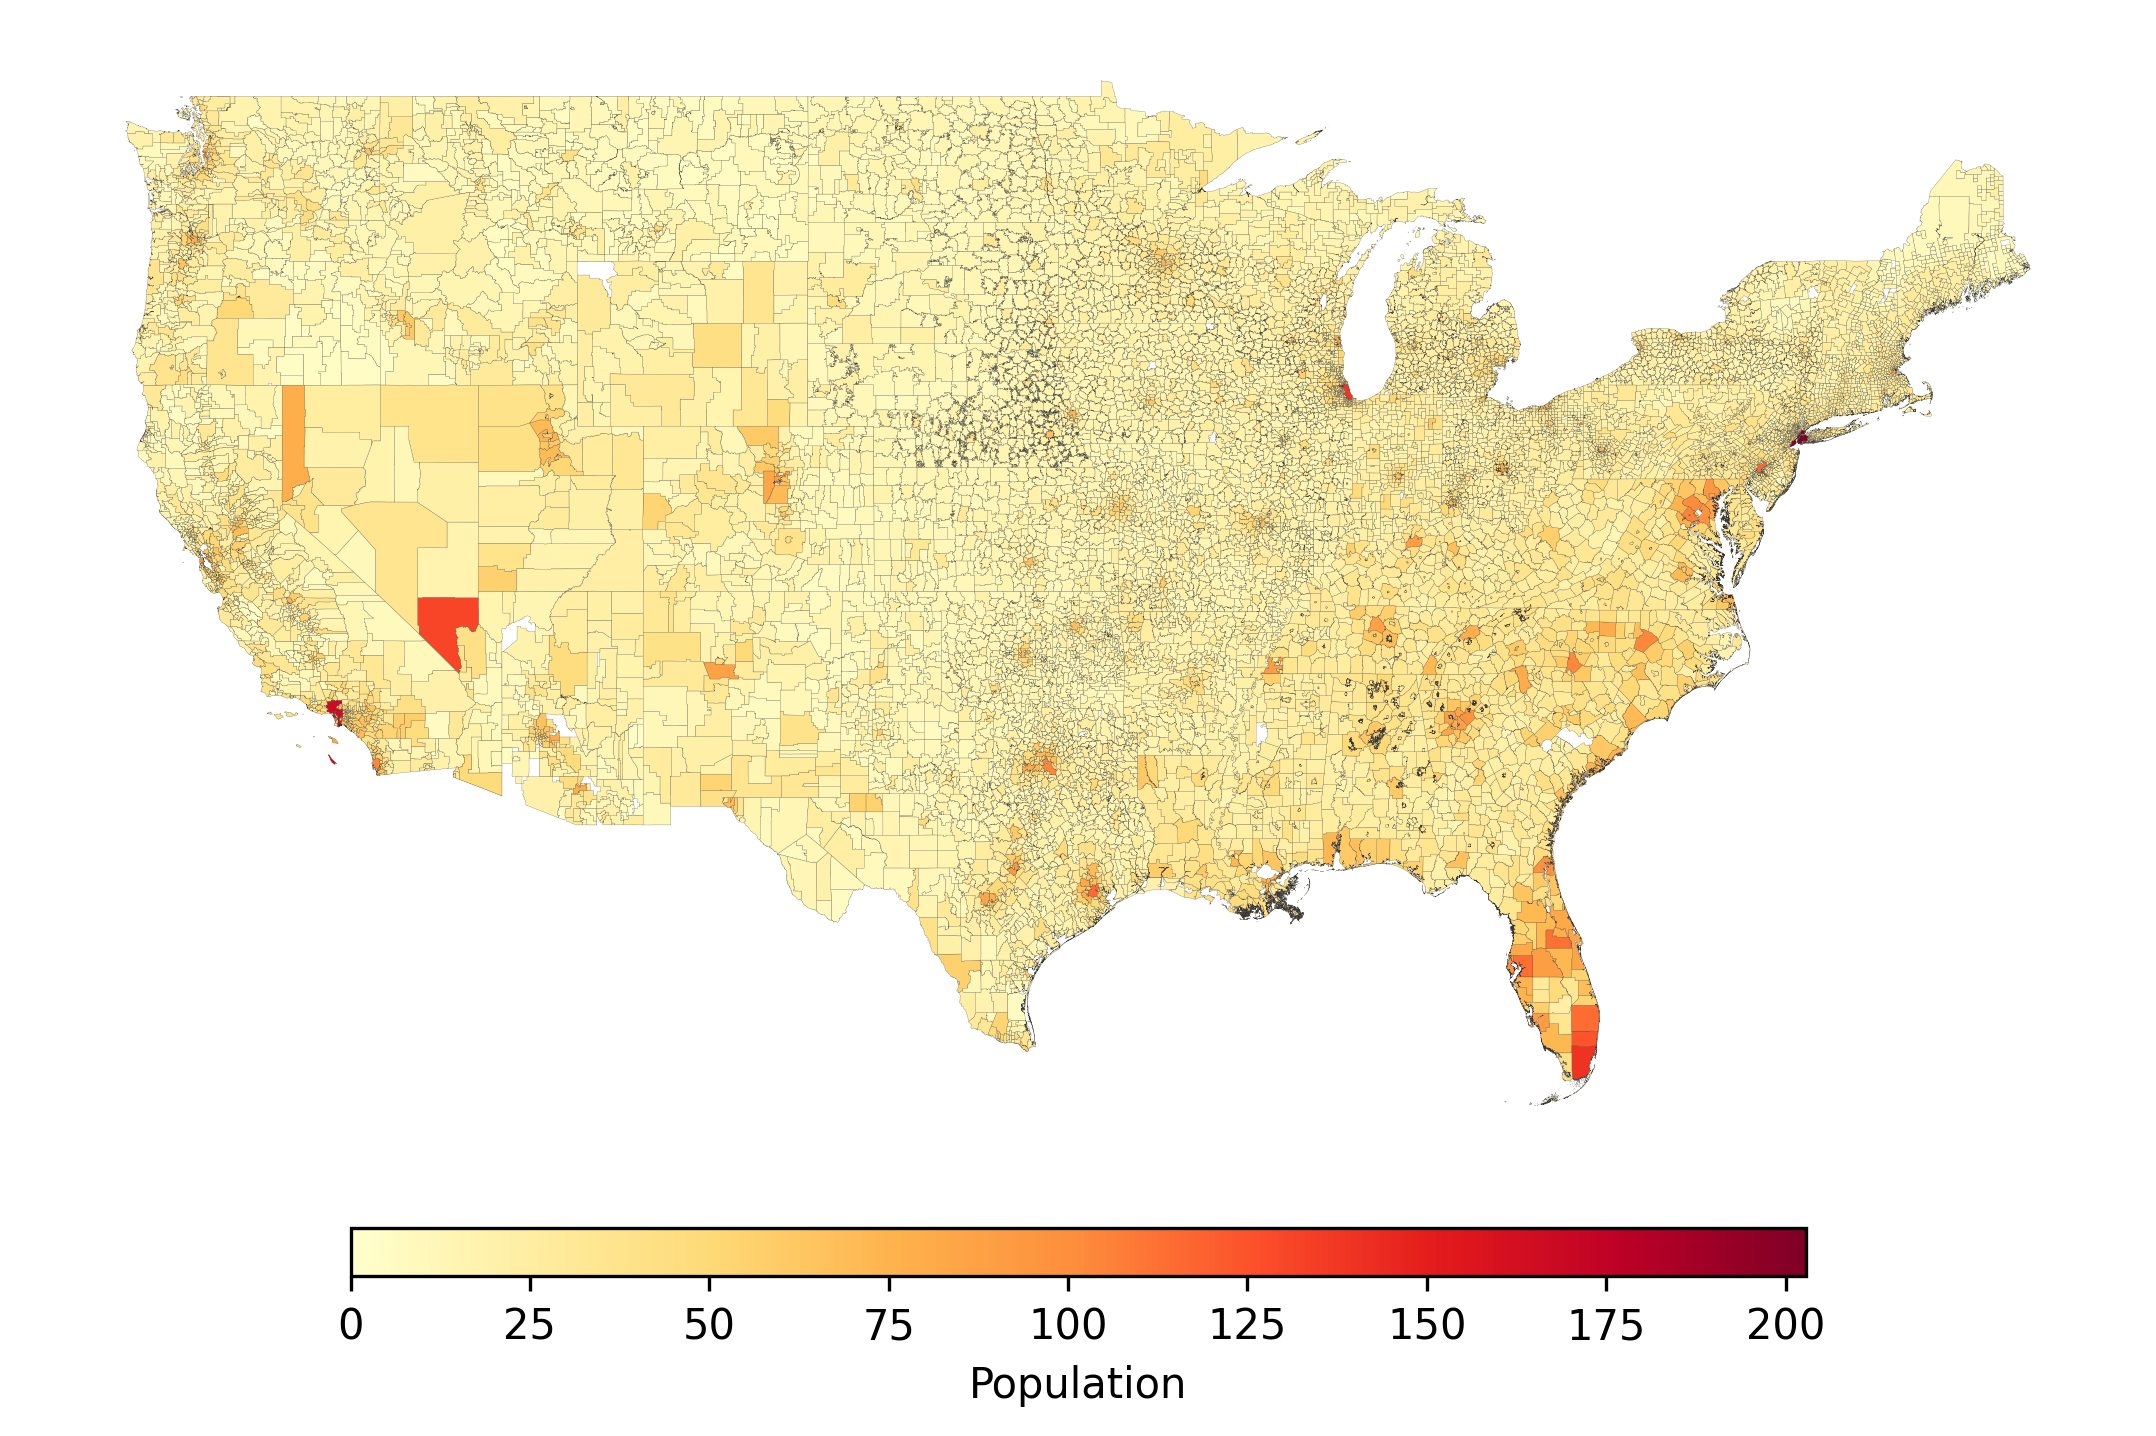

In [52]:
heatmap(
    joined.loc[[
        f for f in joined.index.get_level_values("State FIPS Code").unique()
        if f not in [2, 15]
    ]],
    "Population",
    vcenter=None,
    y="true_pop_total",
    theme="YlOrRd"
)

In [12]:
joined_acs = joined.join(acs['White (RACE) - pct'], how="inner")
joined_acs["prop_nonwhite"] = 1 - acs['White (RACE) - pct'] / 100
joined_acs.prop_nonwhite.describe()
for state in [
#     (26, "Michigan"),
#     (37, "North Carolina"),
    # (72, "Puerto Rico"),
    (42, "Pennsylvania")
]:
    # heatmap(joined_acs.loc[state[0]], "Prop. non-white-only", y="prop_nonwhite", transform=None, vcenter=None, theme="Blues")
    # heatmap(joined.loc[state[0]], "% switched eligibility for any grant", y="switched_eligibility", transform=None, vcenter=None, theme="Oranges")
    heatmap(
        joined.loc[state[0]], 
        "% became ineligible for any grant", 
        file="ineligible.png",
        y="became_ineligible", 
        transform=None, 
        vcenter=None, 
        theme="Oranges",
        min=0,
        max=1
    )
    heatmap(
        joined.loc[state[0]], 
        "% became ineligible for any grant", 
        file="ineligible_dp.png",
        y="became_ineligible_dp", 
        transform=None, 
        vcenter=None, 
        theme="Oranges",
        min=0,
        max=1
    )
    heatmap(
        joined.loc[state[0]], 
        "% became eligible for any grant", 
        file="eligible.png",
        y="became_eligible", transform=None, vcenter=None, theme="Greens",
        min=0,
        max=1
    )
    heatmap(
        joined.loc[state[0]], 
        "% became eligible for any grant", 
        file="eligible_dp.png",
        y="became_eligible_dp", transform=None, vcenter=None, theme="Greens",
        min=0,
        max=1
    )
    # heatmap(joined.loc[state[0]], f"Misallocation per child in {state[1]} (cube root)")
    # heatmap(joined.loc[state[0]], f"Misallocation per eligible child in {state[1]} (cube root)", y="error_per_child_eligible")
    # heatmap(joined.loc[state[0]], "Log eligible children", y="true_children_eligible", transform='log', vcenter=None, theme="Purples")
    # heatmap(joined.loc[state[0]], "% eligible children", y="percent_eligible", transform=None, vcenter=None, theme="Purples")
    # heatmap(joined.loc[state[0]], "Log population", y="true_pop_total", transform='log', vcenter=None, theme="Greens")
    # heatmap(joined.loc[state[0]], "Log status quo entitlement", y="true_grant_total", transform='log', vcenter=None, theme="Greens")

### Random forest

In [24]:
from sklearn.ensemble import RandomForestRegressor

averaged = results.groupby(["State FIPS Code", "District ID"]).mean().join(acs[variables], how="inner")
averaged["misalloc"] = averaged.est_grant_total - averaged.true_grant_total
averaged = averaged.replace('-', np.nan).replace('250,000+', '250000').dropna()
averaged = averaged.fillna(averaged.mean(skipna=True))

In [25]:
from sklearn.tree import plot_tree, DecisionTreeRegressor

dt = DecisionTreeRegressor(max_depth=4)
features = [
    'Total population (RACE) - est',
    'White (RACE) - pct',
    'Black or African American (RACE) - pct',
#     'Cherokee tribal grouping (RACE) - pct',
#     'Chippewa tribal grouping (RACE) - pct',
#     'Navajo tribal grouping (RACE) - pct',
#     'Sioux tribal grouping (RACE) - pct',
    'Asian (RACE) - pct',
#     'Asian Indian (RACE) - pct',
#     'Chinese (RACE) - pct',
#     'Filipino (RACE) - pct',
#     'Japanese (RACE) - pct',
#     'Korean (RACE) - pct',
#     'Vietnamese (RACE) - pct',
#     'Other Asian (RACE) - pct',
#     'Native Hawaiian (RACE) - pct',
#     'Guamanian or Chamorro (RACE) - pct',
#     'Samoan (RACE) - pct',
#     'Some other race (RACE) - pct',
    'Median household income (dollars) (INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)) - est',
    'Foreign born (PLACE OF BIRTH) - pct',
    'Language other than English (LANGUAGE SPOKEN AT HOME) - pct',
    'Renter-occupied (HOUSING TENURE) - pct'
]
print(averaged[features].columns)
dt.fit(
    averaged[features],
    averaged.misalloc
)

Index(['Total population (RACE) - est', 'White (RACE) - pct',
       'Black or African American (RACE) - pct', 'Asian (RACE) - pct',
       'Median household income (dollars) (INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)) - est',
       'Foreign born (PLACE OF BIRTH) - pct',
       'Language other than English (LANGUAGE SPOKEN AT HOME) - pct',
       'Renter-occupied (HOUSING TENURE) - pct'],
      dtype='object')


DecisionTreeRegressor(max_depth=4)

In [26]:
importances = dt.feature_importances_
print(dt.n_features_)
importances

8


array([9.60892670e-01, 2.06042894e-02, 0.00000000e+00, 1.82353866e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.67654128e-04])

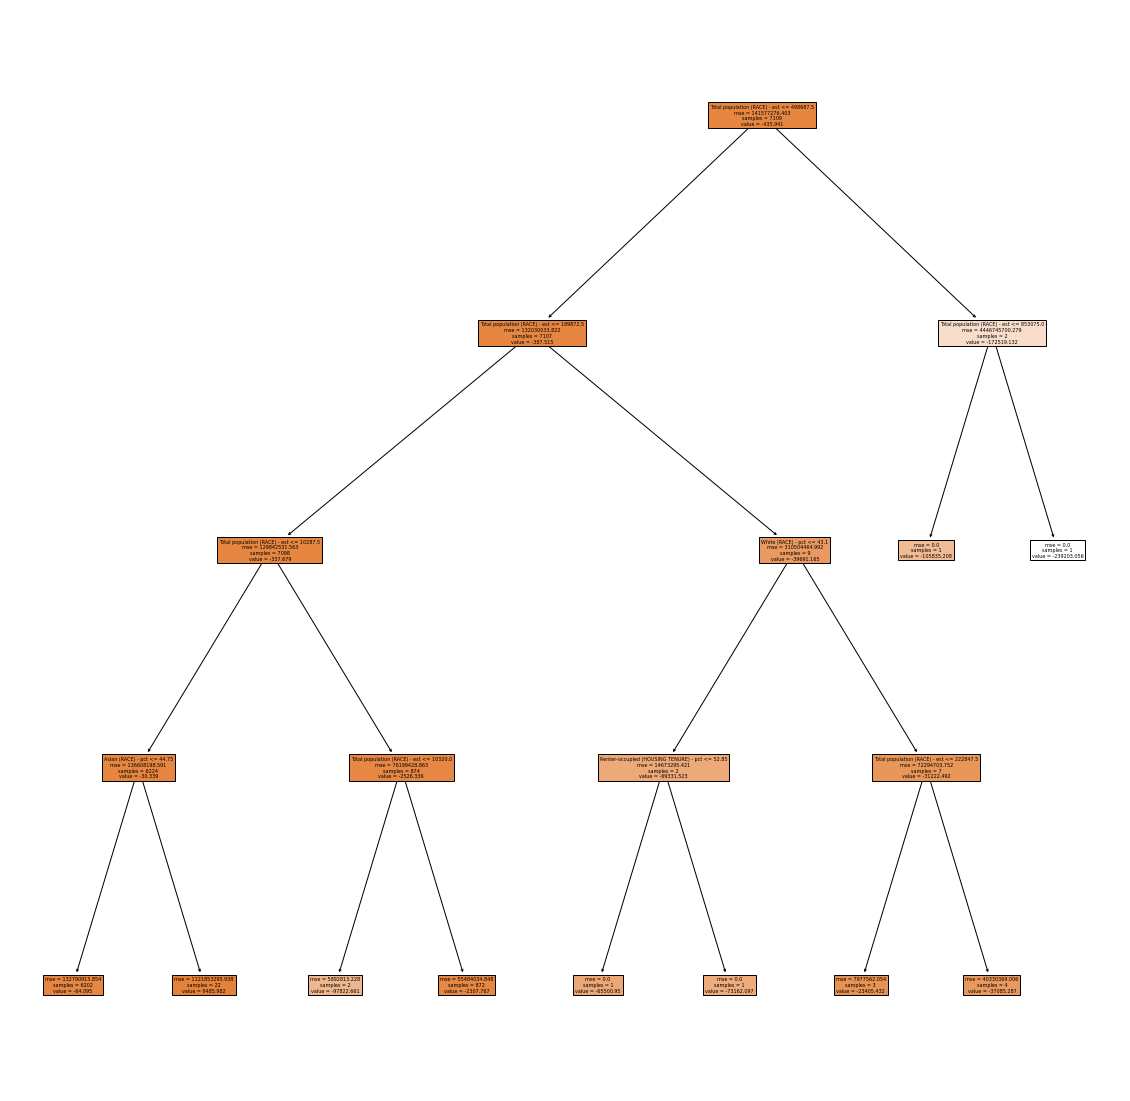

In [27]:
plt.rcParams['figure.figsize'] = [20, 20]
plot_tree(
    dt,
    feature_names = features,
    filled=True
)
plt.show()

### Plot for just (2.52, 0.0)-DP

In [18]:
grants = calc_total(funding(saipe, SonnenbergAuthorizer, Laplace(saipe, 2.52, 0), get_sppe("../data/sppe18.xlsx"), weighting))
grants_gaus = calc_total(funding(saipe, SonnenbergAuthorizer, Gaussian(saipe, 2.52, 0.2), get_sppe("../data/sppe18.xlsx"), weighting))
error = grants.true_grant_total/sum(grants.true_grant_total) - grants.est_grant_total/sum(grants.est_grant_total)
error_gaus = grants_gaus.true_grant_total/sum(grants_gaus.true_grant_total) - grants_gaus.est_grant_total/sum(grants_gaus.est_grant_total)

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


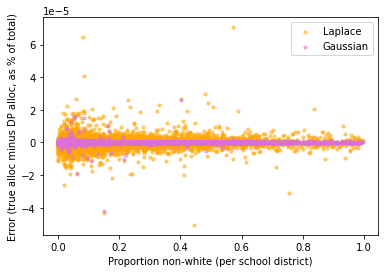

In [241]:
grants['prop_nonwhitealone'] = 1 - grants.race_2est / grants.race_1est
grants.prop_nonwhitealone[saipe.prop_nonwhitealone.isna()] = 0

plt.scatter(grants.prop_nonwhitealone, error, s=10, alpha=0.5, color='orange', label="Laplace")
plt.scatter(grants.prop_nonwhitealone, error_gaus, s=10, alpha=0.5, color='orchid', label="Gaussian")
ax = plt.gca()
ax.legend()
plt.xlabel("Proportion non-white (per school district)")
plt.ylabel("Error (true alloc minus DP alloc, as % of total)")
plt.show()

## Experimental treatments

In [99]:
trials = 100
eps = [0.01, 0.1, 2.52]
delta = [0.0]
baseline = load_treatments("baseline")

In [ ]:
baseline = test_params(saipe, Laplace, eps=eps, delta=delta, trials=trials, print_results=False, allocator_kwargs={'verbose': False})
save_treatments(baseline, "baseline")

### Hold harmless provision

In [101]:
hold_harmless = test_params(
    saipe, Laplace,
    eps=[0.1], delta=delta, trials=trials, print_results=False, 
    allocator_kwargs={'hold_harmless': True}
)
# ground truths are the same
match_true(baseline, [hold_harmless])

# save treatments to file for later
treatments = {
    'No hold harmless': baseline,
    'Hold harmless': hold_harmless
}
save_treatments(treatments, "hold_harmless")

In [102]:
_ = discrimination_treatments_join('hold_harmless')

Comparing at eps= 0.1

# No hold harmless
True budget: 3498472720567.9634
DP est budget: 3498472720567.9575
RMSE over all trials: 918293.2478224252
Avg prop. districts erroneously ineligible: 8734.51
Avg. # of districts losing $$: 19541.02
Total avg. losses: 22119657.07722349
Total avg. losses (data error): 16804142.39699393
Avg. marginal losses (DP): 10484455.329709316

# Hold harmless
True budget: 1166157573522.653
DP est budget: 1166157573522.653
RMSE over all trials: 639107.5607806331
Avg prop. districts erroneously ineligible: 2441.34
Avg. # of districts losing $$: 5179.62
Total avg. losses: 15887788.603463382
Total avg. losses (data error): 15330050.814491013
Avg. marginal losses (DP): 2714358.2842166726


/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


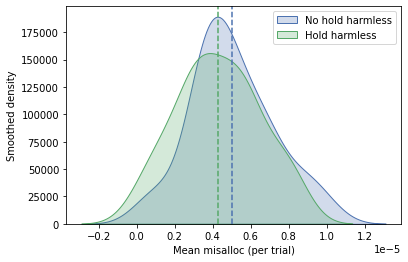

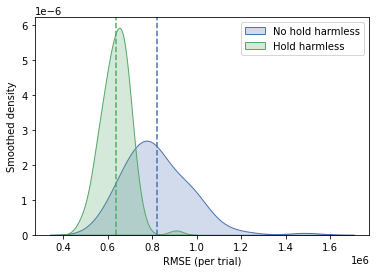

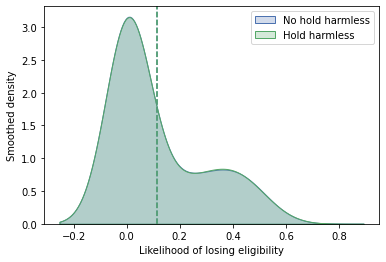

Plotting error_per_child


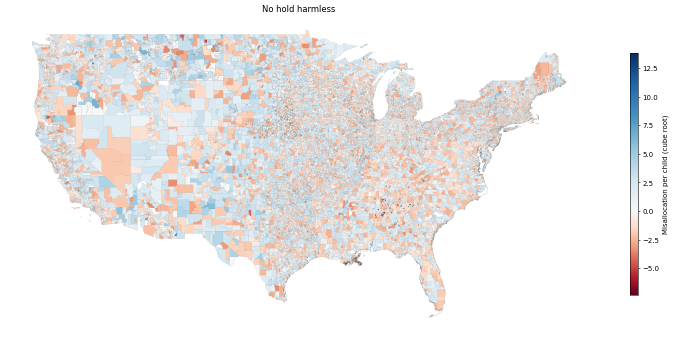

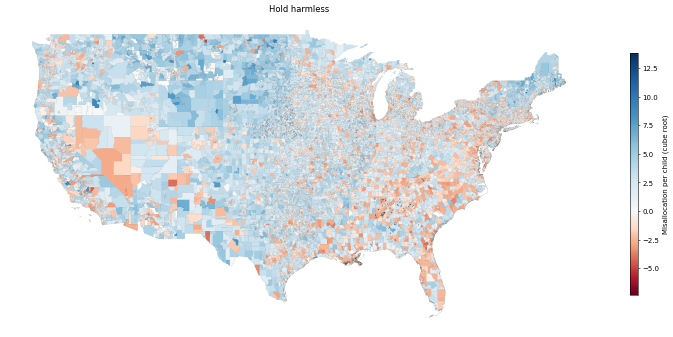

In [103]:
treatments = load_treatments('hold_harmless')
compare_treatments(treatments, experiment_name='hold_harmless')

### Post-processing

In [104]:
none = test_params(
  saipe, Laplace, 
  eps=eps, 
  delta=delta, 
  trials=trials,
  mech_kwargs=dict(
    clip=False,
    round=False
  ),
  print_results=False
)
clipping = baseline
rounding = test_params(
  saipe, Laplace, 
  eps=eps, 
  delta=delta, 
  trials=trials,
  mech_kwargs=dict(
    clip=True,
    round=True
  ),
  print_results=False
)
match_true(baseline, [none, rounding])
treatments = {
    'None': none,
    'Clipping': clipping,
    'Rounding': rounding
}
save_treatments(treatments, "post_processing")

300 iters:


trial:   0%|          | 0/100 [00:00<?, ?it/s]

300 iters:


trial:   0%|          | 0/100 [00:00<?, ?it/s]

In [105]:
_ = discrimination_treatments_join('post_processing')

Comparing at eps= 0.1

# None
True budget: 3498472720567.9634
DP est budget: 3498472720567.9614
RMSE over all trials: 889511.000225023
Avg prop. districts erroneously ineligible: 9042.47
Avg. # of districts losing $$: 19715.71
Total avg. losses: 21569955.33103781
Total avg. losses (data error): 16791137.99328362
Avg. marginal losses (DP): 9915319.509719055

# Clipping
True budget: 3498472720567.9634
DP est budget: 3498472720567.9575
RMSE over all trials: 918293.2478224252
Avg prop. districts erroneously ineligible: 8734.51
Avg. # of districts losing $$: 19541.02
Total avg. losses: 22119657.07722349
Total avg. losses (data error): 16804142.39699393
Avg. marginal losses (DP): 10484455.329709316

# Rounding
True budget: 3498472720567.9634
DP est budget: 3498472720567.9614
RMSE over all trials: 906462.3579223665
Avg prop. districts erroneously ineligible: 8762.49
Avg. # of districts losing $$: 19542.21
Total avg. losses: 22117271.970239963
Total avg. losses (data error): 16811148.530886695

/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


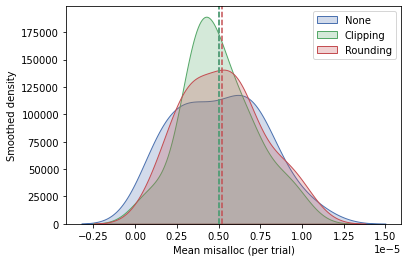

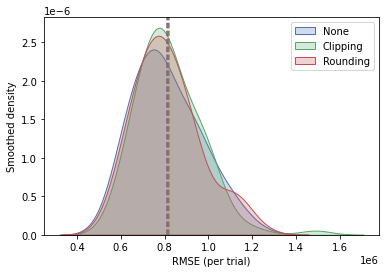

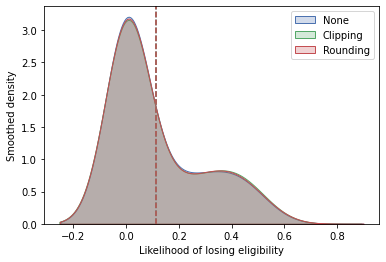

Plotting dp_marginal


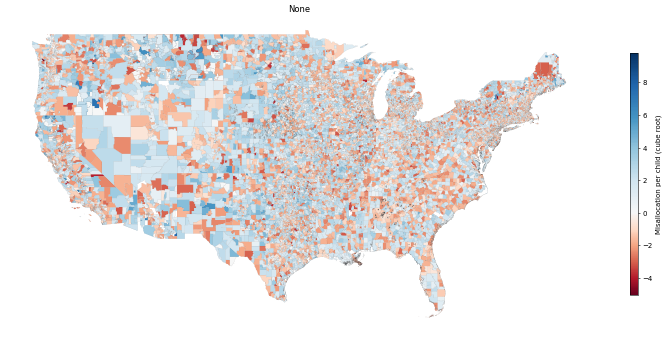

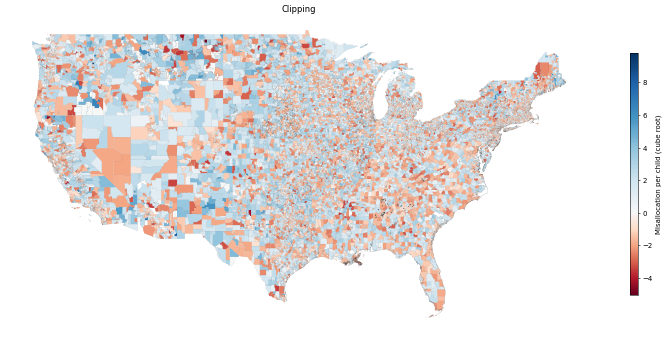

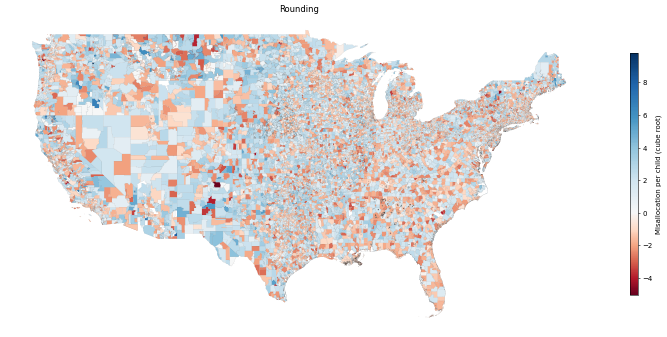

In [106]:
treatments = load_treatments('post_processing')
compare_treatments(treatments, mapvar="dp_marginal", experiment_name='post_processing')

### Moving average

In [107]:
single_year = baseline
averaged = [
  test_params(
    get_inputs(2021, avg_lag=i+1),
    Laplace, 
    eps=eps, 
    delta=delta, 
    trials=trials,
    print_results=False
  )
  for i in range(4)
]

SpecificationError: Column(s) ['cv'] do not exist

In [ ]:
treatments = {
  'lag_0': single_year,
  **{f"lag_{i+1}": a for i, a in enumerate(averaged)}
}
save_treatments(treatments, "moving_average_truth=unmodified")

In [ ]:
_ = discrimination_treatments_join('moving_average_truth=unmodified')

In [ ]:
match_true(averaged[-1], [single_year] + averaged[:-1])
treatments = {
  'lag_0': single_year,
  **{f"lag_{i+1}": a for i, a in enumerate(averaged)}
}
save_treatments(treatments, "moving_average_truth=average")

In [ ]:
_ = discrimination_treatments_join('moving_average_truth=average')

In [ ]:
single_year = baseline
match_true(single_year, averaged)
treatments = {
  'lag_0': single_year,
  **{f"lag_{i+1}": a for i, a in enumerate(averaged)}
}
save_treatments(treatments, "moving_average")

/Users/steed/dp-acs/dp_policy/titlei/evaluation.py:113: DtypeWarning: Columns (183,184,185,186) have mixed types.Specify dtype option on import or set low_memory=False.
  discrimination_joined = discrimination_join(
/Users/steed/dp-acs/dp_policy/titlei/evaluation.py:113: DtypeWarning: Columns (161,162,279,280,283,284,287,288,291,292,295,296,299,300,303,304,307,308,315,316,319,320) have mixed types.Specify dtype option on import or set low_memory=False.
  discrimination_joined = discrimination_join(


In [ ]:
_ = discrimination_treatments_join('moving_average')

In [ ]:
treatments = load_treatments('moving_average')
compare_treatments(treatments, experiment_name='moving_average')

In [ ]:
treatments = load_treatments('moving_average_truth=unmodified')
compare_treatments(treatments, experiment_name='moving_average_truth=unmodified')

In [ ]:
treatments = load_treatments('moving_average_truth=average')
compare_treatments(treatments, experiment_name='moving_average_truth=average')

### Alternative thresholding

In [ ]:
# hard threshold
hard = baseline

# use average 
averaged = test_params(
  saipe,
  Laplace, 
  eps=eps,
  delta=delta,
  trials=trials,
  allocator_kwargs={
    'thresholder': AverageThresholder(5)
  },
  print_results=False
)

# must be ineligible 2x in a row
repeat2 = test_params(
  saipe,
  Laplace, 
  eps=eps,
  delta=delta,
  trials=trials,
  allocator_kwargs={
    'thresholder': RepeatThresholder(1)
  },
  print_results=False
)

# must be ineligible 3x in a row
repeat3 = test_params(
  saipe,
  Laplace, 
  eps=eps,
  delta=delta,
  trials=trials,
  allocator_kwargs={
    'thresholder': RepeatThresholder(2)
  },
  print_results=False
)

# no threshold
none = test_params(
  saipe,
  Laplace, 
  eps=eps,
  delta=delta,
  trials=trials,
  allocator_kwargs={
    'thresholder': DummyThresholder()
  },
  print_results=False
)

# moe
moe_01 = test_params(
  saipe,
  Laplace, 
  eps=eps,
  delta=delta,
  trials=trials,
  allocator_kwargs={
    'thresholder': MOEThresholder(alpha=0.1)
  },
  print_results=False
)
moe_05 = test_params(
  saipe,
  Laplace, 
  eps=eps,
  delta=delta,
  trials=trials,
  allocator_kwargs={
    'thresholder': MOEThresholder(alpha=0.5)
  },
  print_results=False
)

match_true(hard, [averaged, repeat2, repeat3, none, moe_01, moe_05])
treatments = {
  'none': none,
  'hard': hard,
  'average': averaged,
  'repeat_years=2': repeat2,
  'repeat_years=3': repeat3,
  'moe_alpha=0.1': moe_01,
  'moe_alpha=0.5': moe_05
} 
save_treatments(treatments, "thresholds")

300 iters:


trial:   0%|          | 0/100 [00:00<?, ?it/s]

300 iters:


trial:   0%|          | 0/100 [00:00<?, ?it/s]

300 iters:


trial:   0%|          | 0/100 [00:00<?, ?it/s]

300 iters:


trial:   0%|          | 0/100 [00:00<?, ?it/s]

300 iters:


trial:   0%|          | 0/100 [00:00<?, ?it/s]

300 iters:


trial:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
_ = discrimination_treatments_join("thresholds")

In [ ]:
treatments = load_treatments('thresholds')
compare_treatments(treatments, experiment_name='thresholds')

### Epsilon Sensitivity

In [56]:
treatments = {
    f"eps={e}": test_params(
      saipe, Laplace, 
      eps=[e], delta=delta, trials=trials, print_results=False
  ) if e not in eps else baseline.loc[pd.IndexSlice[:, 0.0, e, :, :], :].copy()
  for e in [1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
}
save_treatments(treatments, "epsilon")

100 iters:


trial:   0%|          | 0/100 [00:00<?, ?it/s]

100 iters:


trial:   0%|          | 0/100 [00:00<?, ?it/s]

100 iters:


trial:   0%|          | 0/100 [00:00<?, ?it/s]

100 iters:


trial:   0%|          | 0/100 [00:00<?, ?it/s]

In [92]:
_ = discrimination_treatments_join('epsilon', epsilon=None)

[WARN] Epsilon is none - only use this if there is only one eps value in the df.
# eps=0.0001
True budget: 1166157573522.653
DP est budget: 1166157573522.6536
RMSE: 5369793.670579831
Avg prop. districts erroneously ineligible: 0.43123123578468536
# eps=0.001
True budget: 1166157573522.653
DP est budget: 1166157573522.653
RMSE: 3844118.862140799
Avg prop. districts erroneously ineligible: 0.4324306292645944
# eps=0.01
True budget: 1166157573522.653
DP est budget: 1166157573522.6533
RMSE: 1071016.4932570627
Avg prop. districts erroneously ineligible: 0.3234958301743745
# eps=0.1
True budget: 1166157573522.653
DP est budget: 1166157573522.6538
RMSE: 833316.9135189069
Avg prop. districts erroneously ineligible: 0.18464897649734646
# eps=1
True budget: 1166157573522.653
DP est budget: 1166157573522.6533
RMSE: 838337.5243881051
Avg prop. districts erroneously ineligible: 0.1550606520090978
# eps=10
True budget: 1166157573522.653
DP est budget: 1166157573522.653
RMSE: 815677.8620544741
Avg pr

/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages

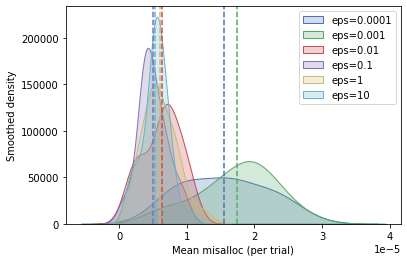

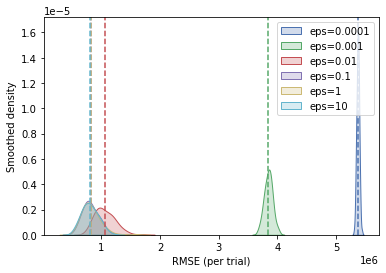

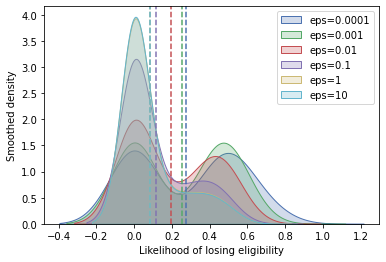

Plotting error_per_child


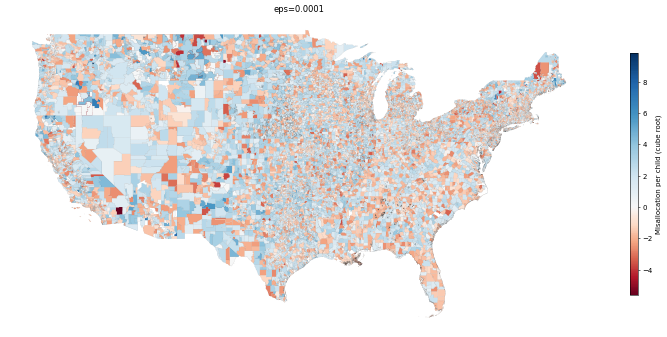

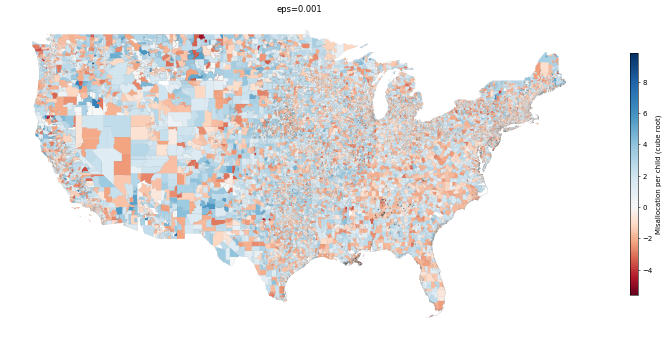

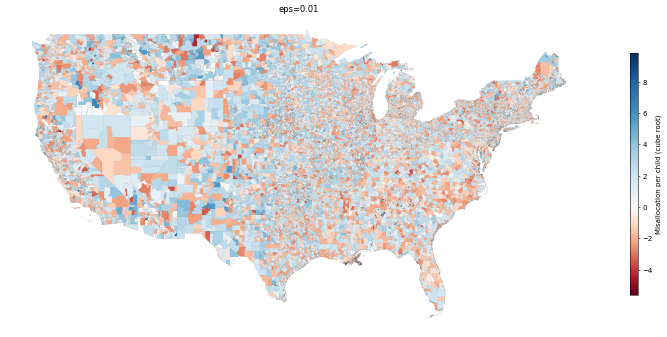

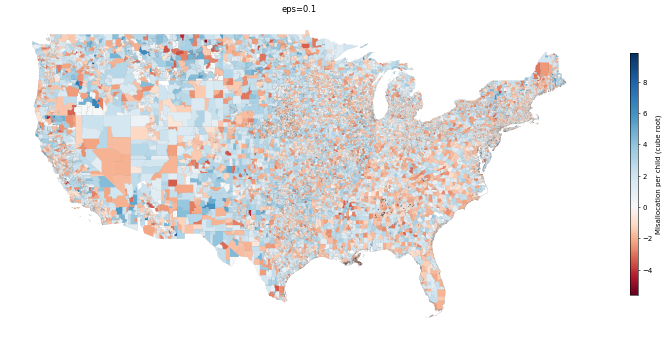

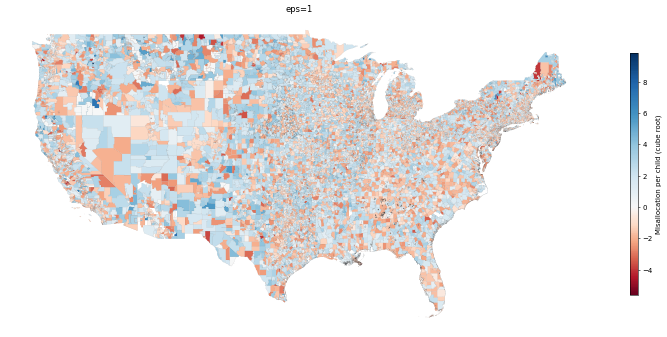

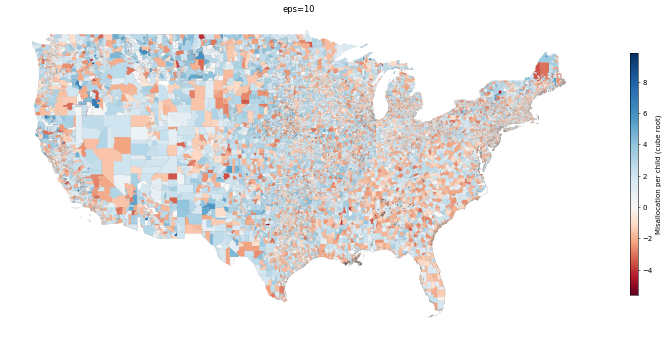

In [58]:
treatments = load_treatments('epsilon')
compare_treatments(treatments, experiment_name='epsilon', epsilon=None)

### Budget increases

In [87]:
e = 0.1
alpha = 0.05

test = baseline.loc[pd.IndexSlice[:, 0.0, e, :, :], :]

budgets = {
  "Biden proposal ($2.0e+10)": 2e10
}
for name, prefixes in {
  "+ exp. loss": ("dpest", "true"),
  "+ exp. marginal loss (DP)": ("dpest", "est"),
  "+ exp. loss (data error)": ("est", "true")
}.items():
  error = test[f"{prefixes[1]}_grant_total"] \
      - test[f"{prefixes[0]}_grant_total"]
  err_grouped = error.groupby(
      ["State FIPS Code", "District ID"]
  )
  exp_error = err_grouped.mean()

  budgets[name] = exp_error[exp_error < 0].abs().sum()

  if prefixes == ("dpest", "true"):
    # how much money to remove alpha quantile loss?
    quantile = err_grouped.quantile(alpha)
    budgets[f"+ {(alpha)*100}% quant. loss"] = quantile[quantile < 0].abs().sum()

    # how much money to cover all misallocated dollars?
    budgets[f"+ exp. misalloc."] = exp_error.abs().sum()

budgets = {"{} (${:.1e})".format(k, v): v for k, v in budgets.items()}

usual_budget = test["official_total_alloc"].groupby(["State FIPS Code", "District ID"]).first().sum()
print("baseline budget: {:.1e}".format(usual_budget))
print(budgets)

treatments = {
    name: test_params(
      saipe, Laplace, 
      eps=[e], delta=delta, trials=trials, print_results=False, 
      allocator_kwargs={'appropriation': round(budget + usual_budget, 2)}
    ) for name, budget in budgets.items()
}
match_true(baseline, list(treatments.values()))
treatments["Baseline appropriation"] = test

save_treatments(treatments, "budget")

baseline budget: 1.6e+10
{'Biden proposal ($2.0e+10) ($2.0e+10)': 20000000000.0, '+ exp. loss ($1.7e+08)': 174169377.55211157, '+ 5.0% quant. loss ($4.6e+09)': 4601341961.954321, '+ exp. misalloc. ($3.5e+08)': 348338755.1042236, '+ exp. marginal loss (DP) ($5.0e+07)': 50069326.48881422, '+ exp. loss (data error) ($1.5e+08)': 151082549.42265162}
100 iters:


trial:   0%|          | 0/100 [00:00<?, ?it/s]

100 iters:


trial:   0%|          | 0/100 [00:00<?, ?it/s]

100 iters:


trial:   0%|          | 0/100 [00:00<?, ?it/s]

100 iters:


trial:   0%|          | 0/100 [00:00<?, ?it/s]

100 iters:


trial:   0%|          | 0/100 [00:00<?, ?it/s]

100 iters:


trial:   0%|          | 0/100 [00:00<?, ?it/s]

In [89]:
_ = discrimination_treatments_join('budget')

Comparing at eps= 0.1

# Biden proposal ($2.0e+10) ($2.0e+10)
True budget: 1166157573522.653
DP est budget: 2639266048736.399
RMSE over all trials: 6999746.17284533
Avg prop. districts erroneously ineligible: 2435.66
Avg. # of districts losing $$: 1699.92
Total avg. losses: 5900413.982359329
Total avg. losses (data error): 5762452.287511622
Avg. marginal losses (DP): 6886554.436151608

# + exp. loss ($1.7e+08)
True budget: 1166157573522.653
DP est budget: 1178986092832.508
RMSE over all trials: 859350.0648828121
Avg prop. districts erroneously ineligible: 2446.69
Avg. # of districts losing $$: 6189.05
Total avg. losses: 17124948.403121945
Total avg. losses (data error): 16504982.415216133
Avg. marginal losses (DP): 3078671.1498007956

# + 5.0% quant. loss ($4.6e+09)
True budget: 1166157573522.653
DP est budget: 1505071365598.1243
RMSE over all trials: 1803202.1296051273
Avg prop. districts erroneously ineligible: 2438.72
Avg. # of districts losing $$: 3731.59
Total avg. losses: 1011122

/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


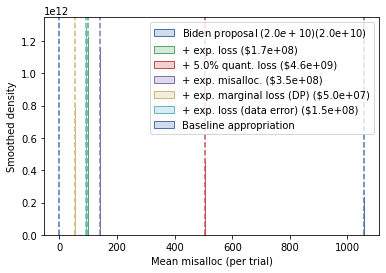

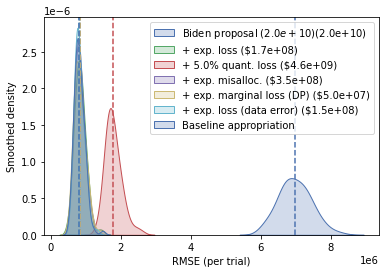

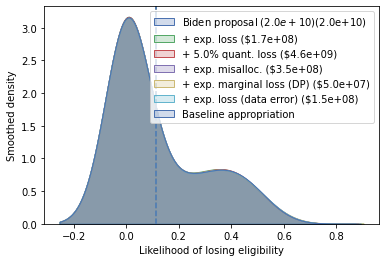

Plotting error_per_child


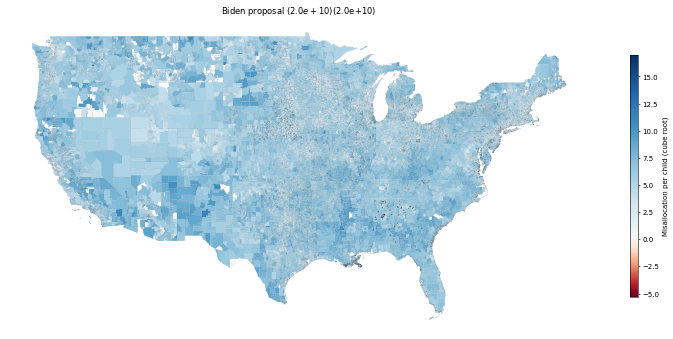

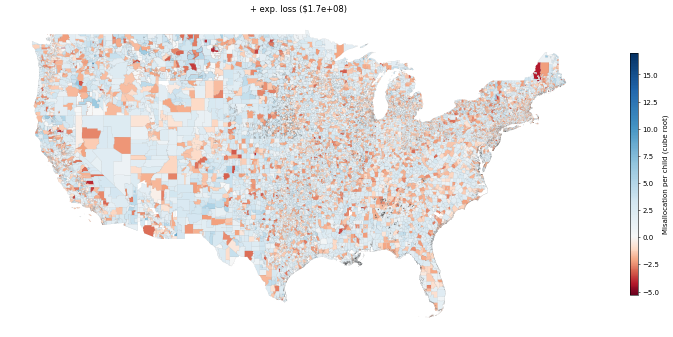

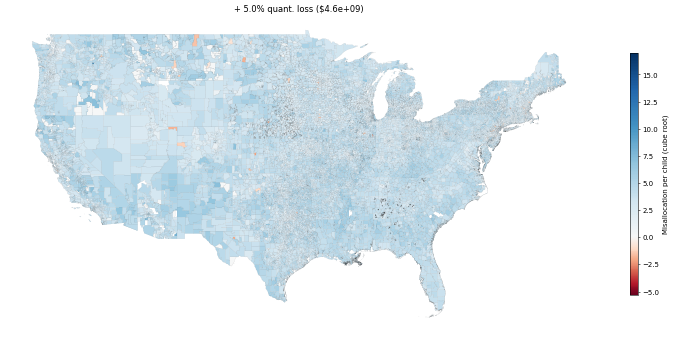

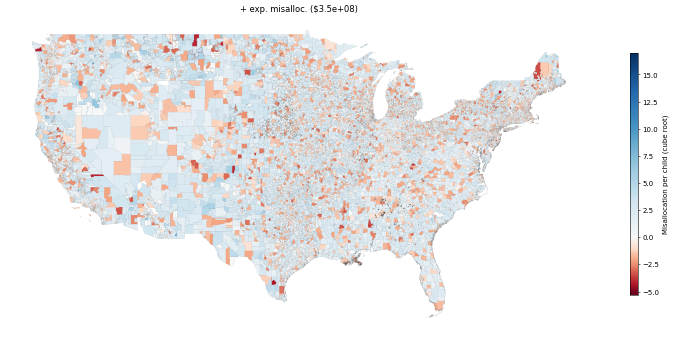

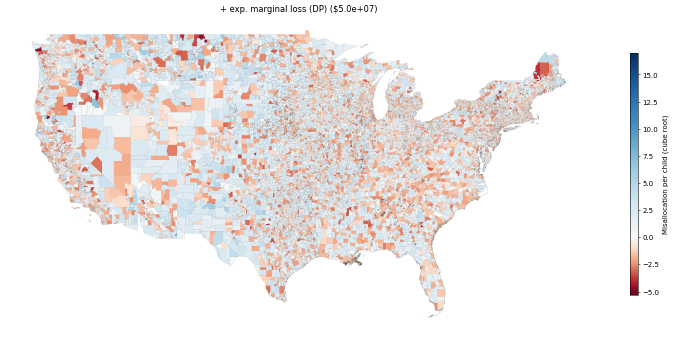

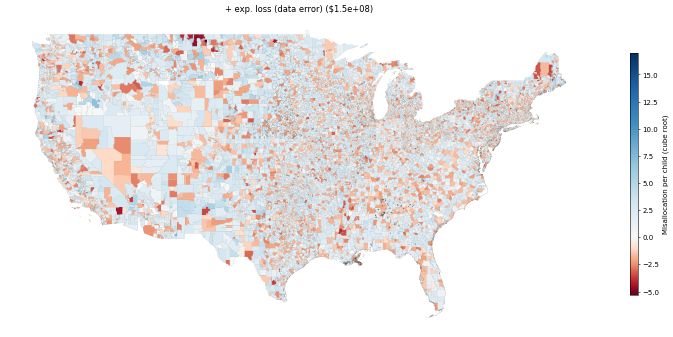

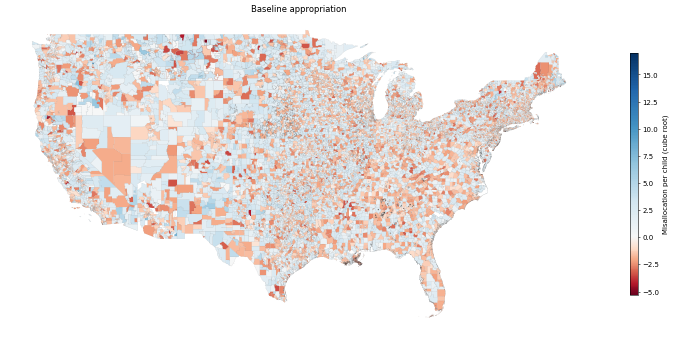

In [90]:
treatments = load_treatments('budget')
compare_treatments(treatments, experiment_name='budget', epsilon=e)